In [98]:
"""
记得每次训练更改新的model name用以分别保存模型参数文件
可以通过dataset id来选择三个数据集中的一个
"""

m_name = 'bertlinear_bbc_z0' # model name, bbc = 'bert-base-chinese
dsid = 2 # dataset id = ['/bq_corpus','/lcqmc','/paws-x-zh'], 千言文本相似度比赛三个数据集是分开记分的

In [99]:
debug = 1
seed = 218

# Model hyperparameter
device = 'cuda'
bert_model = 'bert-base-chinese' # 'hfl/chinese-roberta-wwm-ext'
freeze_bert = False
maxlen = 128
finetune_units = 768
dropout_rate = 0.1

#　Train Hyperparameter
bs = 200
lr = 2e-5 #1e-3 #2e-5
if debug:
    epochs = 4
    num_warmup_steps = 0
else:
    epochs = 8
    num_warmup_steps = 2
es_counts_MAX = 3
# Postprocess hyperparameter
thres = 0.5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
!pip install transformers

In [100]:
from scipy.spatial import distance
from scipy.spatial.distance import cosine
import nltk
from scipy.stats import pearsonr

import sys
import os
import numpy as np 
import pandas as pd
import copy
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn
import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

#float16和float32自动混合精度加速计算，官方文档：https://pytorch.org/docs/stable/amp.html
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [12]:
! pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 24.9 MB 19.5 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=03bb4c8737f99aa37e59104f12b1a69bcc0a48cb7694766b2607095b85b75ea7
  Stored in directory: /home/bool_tbb/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [101]:
def set_seed(seed = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    return seed

seed = set_seed(seed)

In [7]:
# PATH Info
CURR_PATH = os.getcwd()
#ROOT_PATH = CURR_PATH + '/drive/MyDrive/Baidu_Qianyan'

In [8]:
CURR_PATH ='/home/bool_tbb/jupyter_notebook/CPT_SS/model/'

In [102]:
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
		os.makedirs(path)            #makedirs 创建文件时如果路径不存在会创建这个路径
		print('---  New Model Folder: {}  ---'.format(m_name))
 
	else:
		print('---  Model Dir Exsiting!  ---')

def read_tsv(input_file):
    with open(input_file,"r",encoding="utf-8") as file:
        lines = []
        for line in file:
            if len(line.strip().split("\t")) != 1:
                lines.append(line.strip().split("\t"))
        df = pd.DataFrame(lines)
    return df

DATASET_PATH = ['/bq_corpus','/lcqmc','/paws-x-zh']
dataset_path = DATASET_PATH[dsid]
#ROOT_PATH = '/content/drive/MyDrive/Baidu_Qianyan'
path1 = '../Data'
DATA_PATH = ['/train.tsv','/dev.tsv','/test.tsv']
#MODEL_SAVE_PATH = ROOT_PATH + '/model' + dataset_path + '/' + m_name 
MODEL_SAVE_PATH =  '../../model/'+m_name
#mkdir(MODEL_SAVE_PATH)     

train = pd.DataFrame()
dev = pd.DataFrame()
test = pd.DataFrame()
for data_path in DATA_PATH:
    #PATH = ''.join([ROOT_PATH,dataset_path])
    #PATH = ''.join([dataset_path,data_path])
    PATH = ''.join([path1,dataset_path])
    PATH = ''.join([PATH,dataset_path])
    PATH = ''.join([PATH,data_path])
    df = read_tsv(PATH)
    if data_path == '/train.tsv':
        train = pd.concat([train,df],axis = 0)
    if data_path == '/dev.tsv':
        dev = pd.concat([dev,df],axis = 0)
    if data_path == '/test.tsv':
        test = pd.concat([test,df],axis = 0)

## bq_corpus在20746行的格式有问题，以下方法无法读取
# train = pd.DataFrame()
# for dataset_path in DATASET_PATH:
#     print(dataset_path)
#     for data_path in DATA_PATH:
#         PATH = ''.join([ROOT_PATH,dataset_path])
#         PATH = ''.join([PATH,data_path])
#         read_df = pd.read_csv(PATH, header=0, delimiter='\t')
#         train.append(read_df)

train[[2]] = train[[2]].astype(int)
dev[[2]] = dev[[2]].astype(int)

In [75]:
mkdir(MODEL_SAVE_PATH)

---  Model Dir Exsiting!  ---


In [76]:
MODEL_SAVE_PATH

'../../model/bertlinear_bbc_z0'

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49129 entries, 0 to 49128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       49129 non-null  object
 1   1       49129 non-null  object
 2   2       49129 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [104]:
train.describe()

,2
count,49129.000000
mean,0.441369
std,0.496556
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [105]:
cols_dict=['sentence_a', 'sentence_b', 'similarity']
train.columns = cols_dict
dev.columns = cols_dict
test.columns = cols_dict[:2]

In [106]:
train.head()

,sentence_a,sentence_b,similarity
0,1560年10月，他在巴黎秘密会见了英国大使Nicolas Throckmorton，要求他...,1560年10月，他在巴黎秘密会见了英国大使尼古拉斯·斯罗克莫顿，并要求他通过英格兰返回苏格...,0
1,1975年的NBA赛季 - 76赛季是全美篮球协会的第30个赛季。,1975-76赛季的全国篮球协会是NBA的第30个赛季。,1
2,还有具体的讨论，公众形象辩论和项目讨论。,还有公开讨论，特定档案讨论和项目讨论。,0
3,当可以保持相当的流速时，结果很高。,当可以保持可比较的流速时，结果很高。,1
4,它是Akmola地区Zerendi区的所在地。,它是Akmola地区Zerendi区的所在地。,1


In [107]:
train['len_a']=train['sentence_a'].map(lambda x: len(x))
train['len_b']=train['sentence_b'].map(lambda x: len(x))
train.describe()

,similarity,len_a,len_b
count,49129.000000,49129.000000,49129.000000
mean,0.441369,44.659977,44.643469
std,0.496556,17.926405,17.844421
min,0.000000,7.000000,3.000000
25%,0.000000,31.000000,32.000000
50%,0.000000,42.000000,42.000000
75%,1.000000,55.000000,55.000000
max,1.000000,149.000000,149.000000


In [108]:
if debug:
    df_train = train.iloc[2000:20000,:].reset_index(drop = True)
    df_val = train.iloc[:2000,:]
else:
    df_train = train
    df_val = dev
df_val.head()

,sentence_a,sentence_b,similarity,len_a,len_b
0,1560年10月，他在巴黎秘密会见了英国大使Nicolas Throckmorton，要求他...,1560年10月，他在巴黎秘密会见了英国大使尼古拉斯·斯罗克莫顿，并要求他通过英格兰返回苏格...,0,56,51
1,1975年的NBA赛季 - 76赛季是全美篮球协会的第30个赛季。,1975-76赛季的全国篮球协会是NBA的第30个赛季。,1,34,28
2,还有具体的讨论，公众形象辩论和项目讨论。,还有公开讨论，特定档案讨论和项目讨论。,0,20,19
3,当可以保持相当的流速时，结果很高。,当可以保持可比较的流速时，结果很高。,1,17,18
4,它是Akmola地区Zerendi区的所在地。,它是Akmola地区Zerendi区的所在地。,1,23,23


In [109]:
df_train.head()

,sentence_a,sentence_b,similarity,len_a,len_b
0,改变所选择的测定，改变细胞上的选择压力，因此可以改变转化细胞中使用的性质。,如果所选择的测定法变化，则选择性压力在细胞上改变，因此可以改变转化细胞中使用的特性。,1,37,42
1,办公室搬到德里米尔斯并于1871年2月重新建立，尽管Scio办公室于1871年9月更名。,办公室搬到了德里米尔斯，并于1871年2月重新命名，尽管Scio办公室于1871年9月重建。,0,44,46
2,1844年，布鲁克林从波士顿吞并成为Pill Hill的一部分。,Pill Hill于1844年成为Brookline的一部分，当时它被波士顿吞并。,0,32,41
3,它们构成了西河的大部分人口和里奥内格罗河口上方的沃佩斯河上游。,它们构成了Xié河和Vaupés河口上方Rio Negro上游的大部分人口。,0,31,38
4,可以反转倾斜传感器，以便能够在GBA SP上正确播放。,可以播放倾斜传感器，以便能够在GBA SP上正确地反转它。,0,27,29


In [110]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [ ]:
sent1 = "可以反转倾斜传感器，以便能够在GBA SP上正确播放。"
sent2 = "可以播放倾斜传感器，以便能够在GBA SP上正确地反转它。"

In [46]:
re=tokenizer.encode_plus(sent1,sent2, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

In [47]:
print(re['input_ids'].size())
print(re['token_type_ids'].size())
print(re['attention_mask'].size())


torch.Size([1, 51])
torch.Size([1, 51])
torch.Size([1, 51])


In [111]:
class LoadDataset(Dataset):
    def __init__(self, data, maxlen, with_labels=True, bert_model='bert-base-chinese'):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained(bert_model,output_loading_info = False)  
        self.maxlen = maxlen
        self.with_labels = with_labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = str(self.data.loc[index,'sentence_a'])
        sent2 = str(self.data.loc[index,'sentence_b'])
        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_input1 = self.tokenizer(sent1,sent2, padding='max_length', truncation=True, max_length=self.maxlen, return_tensors='pt')
        #encoded_input1 = self.tokenizer.encode_plus(sent1,sent2, padding='max_length', truncation=True, max_length=self.maxlen, return_tensors='pt')
        token_ids1 =  encoded_input1['input_ids'].squeeze(0) 
        attn_masks1 =  encoded_input1['attention_mask'].squeeze(0)  
        token_type_ids1 =  encoded_input1['token_type_ids'].squeeze(0) 

        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'similarity']
            return token_ids1, attn_masks1, token_type_ids1, label
        else:
            return token_ids1, attn_masks1, token_type_ids1


In [112]:
def val_lossF(net, device, criterion, dataloader):
    net.eval()
    mean_loss = 0
    count = 0
    true_labelss = []
    list_val_outputs = []
    val_metric = 0
    
    with torch.no_grad():
        for  i, (token_ids1, attn_masks1, token_type_ids1,labels) in enumerate(dataloader):
            token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
            labels = labels.to(device)
            
            val_output = net(token_ids1, attn_masks1, token_type_ids1)
            mean_loss += criterion(val_output, labels.float()).item()
            count += 1

            val_outputs = val_output.sigmoid().cpu().numpy()
            val_outputs = np.where(val_outputs>thres, 1, 0)
            list_val_outputs += val_outputs.tolist()
            labelss = labels.cpu().numpy()
            true_labelss += labelss.tolist()  
        val_metric = accuracy_score(list_val_outputs,true_labelss)       
    return mean_loss / count, val_metric

In [113]:
class BertLinear(nn.Module):
    def __init__(self, dropout_rate=0.2, finetune_units=768, bert_model='bert-base-chinese', freeze_bert=False):
        super(BertLinear, self).__init__()
        self.bert_layer1 = BertModel.from_pretrained(bert_model,output_loading_info = False)
        if bert_model == 'bert-base-chinese':
            self.hidden_size = 768
        elif bert_model == 'hfl/chinese-roberta-wwm-ext':
            self.hidden_size = 768
            
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        self.dropout0 = nn.Dropout(p=dropout_rate)
        self.vec_layer = nn.Linear(self.hidden_size,1)
        # self.cs_layer = nn.Sigmoid()
        
    def mean_pooling(self, all_vecs, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(all_vecs.size()).float()
        sum_embeddings = torch.sum(all_vecs * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    @autocast()
    def forward(self,  token_ids1, attn_masks1, token_type_ids1):
        vecs1 = self.bert_layer1(token_ids1, attn_masks1, token_type_ids1)
        #Perform pooling. In this case, mean pooling
        sent_embed1 = self.mean_pooling(vecs1[0], attn_masks1)
        x1 = self.dropout0(sent_embed1)
        x1 = self.vec_layer(x1)

        return x1.squeeze(-1)

In [114]:
device = torch.device(device if torch.cuda.is_available() else "cpu")
net = BertLinear(dropout_rate=dropout_rate, finetune_units=finetune_units,bert_model=bert_model,freeze_bert=freeze_bert)
net.to(device)

BertLinear(
  (bert_layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [115]:
net = nn.DataParallel(net, [0,1,2,3])

In [116]:
train_set = LoadDataset(df_train, maxlen, bert_model)
val_set = LoadDataset(df_val, maxlen, bert_model)
train_loader = DataLoader(train_set, batch_size=bs)
val_loader = DataLoader(val_set, batch_size=bs)

#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
opti = AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
num_training_steps = epochs * len(train_loader)  # The total number of training steps
lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps )
scaler = GradScaler()

best_loss = np.Inf
best_ep = 1
iters = []
train_losses = []
val_losses = []
val_metrics = []
es_count = 0
for ep in range(epochs):
    for it, (token_ids1, attn_masks1, token_type_ids1,labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        net.train()
        
        token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
        labels = labels.to(device)
        opti.zero_grad()
        with autocast():
            output = net(token_ids1, attn_masks1, token_type_ids1)
            loss = criterion(output, labels.float())
        scaler.scale(loss).backward()
        scaler.step(opti)
        scaler.update()      
        lr_scheduler.step()
        
        # if it % 100 == 0:
        #     val_loss, val_metric = val_lossF(net, device, criterion, val_loader)  # Compute validation loss
        #     print("it = {}, train_loss = {}, val_loss = {}, val_metric= {}".format(it+1,loss,val_loss,val_metric))
            
    val_loss, val_metric = val_lossF(net, device, criterion, val_loader)  # Compute validation loss  
    print("Epoch {} complete! Train Loss : {} , Validation Loss : {} , Validation Metric - Accuracy : {} ".format(ep+1, loss, val_loss, val_metric))
    train_losses.append(loss)
    val_losses.append(val_loss)  
    val_metrics.append(val_metric)
    if val_loss < best_loss:       
        print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
        net_copy = copy.deepcopy(net)  # save a copy of the model
        best_loss = val_loss
        best_ep = ep + 1
        path_to_model='ep_{}_val_loss_{}.pt'.format(best_ep, round(best_loss, 4))
        torch.save(net_copy.state_dict(), MODEL_SAVE_PATH + '/' + path_to_model)
        print("The model has been saved in {}".format(path_to_model))
    # else:
    #     es_count += 1
    
    # if early_stop and es_count>es_counts_MAX:
    #     print('Early Stop Train in Epoch : {} '.format(ep+1))
    #     break

del loss
torch.cuda.empty_cache()

100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


Epoch 1 complete! Train Loss : 0.5763872265815735 , Validation Loss : 0.5882046461105347 , Validation Metric - Accuracy : 0.693 
Best validation loss improved from inf to 0.5882046461105347


  0%|          | 0/90 [00:00<?, ?it/s]

The model has been saved in ep_1_val_loss_0.5882.pt


100%|██████████| 90/90 [01:18<00:00,  1.14it/s]


Epoch 2 complete! Train Loss : 0.46009939908981323 , Validation Loss : 0.5149914115667343 , Validation Metric - Accuracy : 0.743 
Best validation loss improved from 0.5882046461105347 to 0.5149914115667343


  0%|          | 0/90 [00:00<?, ?it/s]

The model has been saved in ep_2_val_loss_0.515.pt


100%|██████████| 90/90 [01:20<00:00,  1.12it/s]


Epoch 3 complete! Train Loss : 0.4470978379249573 , Validation Loss : 0.5094869673252106 , Validation Metric - Accuracy : 0.7505 
Best validation loss improved from 0.5149914115667343 to 0.5094869673252106


  0%|          | 0/90 [00:00<?, ?it/s]

The model has been saved in ep_3_val_loss_0.5095.pt


100%|██████████| 90/90 [01:20<00:00,  1.12it/s]


Epoch 4 complete! Train Loss : 0.3799962103366852 , Validation Loss : 0.5084242701530457 , Validation Metric - Accuracy : 0.762 
Best validation loss improved from 0.5094869673252106 to 0.5084242701530457
The model has been saved in ep_4_val_loss_0.5084.pt


In [36]:
transformers.__version__

'2.8.0'

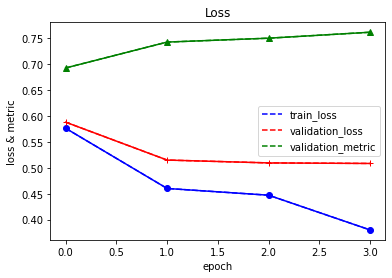

train loss =  [tensor(0.5764, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.4601, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.4471, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), tensor(0.3800, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)]
val loss =  [0.5882046461105347, 0.5149914115667343, 0.5094869673252106, 0.5084242701530457]
val metric =  [0.693, 0.743, 0.7505, 0.762]


In [117]:
p1 = plt.plot(range(epochs),train_losses,'b--',label='train_loss')
p2 = plt.plot(range(epochs),val_losses,'r--',label='validation_loss')
p3 = plt.plot(range(epochs),val_metrics,'g--',label='validation_metric')
plt.plot(range(epochs),train_losses,'bo-',range(epochs),val_losses,'r+-',range(epochs),val_metrics,'g^-')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss & metric')
plt.legend()
plt.show()
print('train loss = ', train_losses)
print('val loss = ', val_losses)
print('val metric = ', val_metrics)


In [39]:
MODEL_SAVE_PATH + '/' + path_to_model

'../../model/bertlinear_bbc_z0/ep_1_val_loss_0.269.pt'

In [118]:
net = BertLinear(dropout_rate=dropout_rate, finetune_units=finetune_units,bert_model=bert_model)
net = nn.DataParallel(net)
net.load_state_dict(torch.load(MODEL_SAVE_PATH + '/' + path_to_model))
net.to(device)

test_set = LoadDataset(test, maxlen, with_labels=False, bert_model = bert_model)
test_loader = DataLoader(test_set, batch_size=bs)

net.eval()
results = []
with torch.no_grad():
    for token_ids1, attn_masks1, token_type_ids1 in tqdm(test_loader):
        token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
        output = net(token_ids1, attn_masks1, token_type_ids1)
        output = output.sigmoid().cpu().numpy()
        output = np.where(output>thres, 1, 0)
        results += output.tolist()

test['similarity'] = results

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


In [68]:
test.to_csv(MODEL_SAVE_PATH+'dataset_path'+'preds.tsv',sep='\t')
test.head(50)

TypeError: to_csv() got an unexpected keyword argument 'delimiter'

In [47]:
MODEL_SAVE_PATH+'/dataset_path/'+'preds.csv'

'../../model/bertlinear_bbc_z0/dataset_path/preds.csv'

In [119]:
ls  = ["index" , "prediction"]
df1=pd.DataFrame(columns=ls,index=None)#数据有三列，列名分别为one,two,three
df1['index']=list(range(len(test)))
df1['prediction']=test['similarity']
print(df1)
df1.to_csv('testcsv_new.csv',encoding='utf8',index=False,sep='\t')

      index  prediction
0         0           1
1         1           0
2         2           0
3         3           0
4         4           1
...     ...         ...
1995   1995           0
1996   1996           1
1997   1997           0
1998   1998           0
1999   1999           0

[2000 rows x 2 columns]
